## Import Packages

In [261]:
# Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

Dimesions: (497, 761, 3)


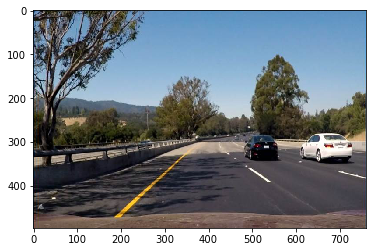

In [268]:
# Reading a sample image
image = mpimg.imread('sample_images/DK2.jpg')

# Printing out the image size and plotting
print('Dimesions:', image.shape)
plt.imshow(image) 

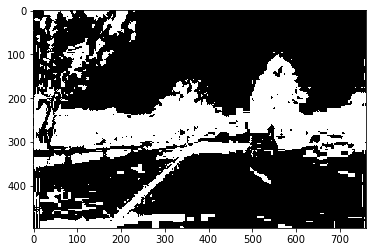

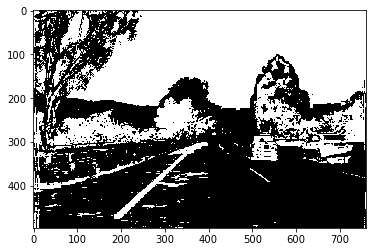

In [274]:
# Binary image of color channel (S_channel/H_channel) 

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# H_channel (Strong against for shadow)
h_channel = hls[:,:,0]
thresh_h = (10,100)
binary_h = np.zeros_like(h_channel)
binary_h[(h_channel > thresh_h[0]) & (h_channel <= thresh_h[1])] = 1
plt.figure(1)
plt.imshow(binary_h, cmap='gray')

# S_channel (Strong against for light)
s_channel = hls[:,:,2]
thresh_s = (60,255)
binary_s = np.zeros_like(s_channel)
binary_s[(s_channel > thresh_s[0]) & (s_channel <= thresh_s[1])] = 1
plt.figure(2)
plt.imshow(binary_s, cmap='gray')

## Class for Tracking the lane

In [275]:
# Line class for Tracking 

class Line():
    def __init__(self, n_smooth): 
        # Number of averaging size
        self.n_smooth=n_smooth
        # Values for draw lines (X_Left_Min, X_Left_Max, X_Right_Min, X_Right_Max)
        self.X1L=[]
        self.X2L=[]
        self.X1R=[]
        self.X2R=[]
        # Initialize average value for each variable
        self.X1L_ave=0
        self.X2L_ave=0
        self.X1R_ave=0
        self.X2R_ave=0
    
    # Calcualte the average 
    def cal_average(self, values):
        # Append each value 
        self.X1L.append(values[0])
        self.X2L.append(values[1])
        self.X1R.append(values[2])
        self.X2R.append(values[3])
        
        # Exceed number of averaging size? 
        if len(self.X1L) > self.n_smooth:
            self.X1L.pop(0)
            self.X2L.pop(0)
            self.X1R.pop(0)
            self.X2R.pop(0)

        else:
            pass
                
        # Averaging 
        self.X1L_ave=int(np.mean(self.X1L))
        self.X2L_ave=int(np.mean(self.X2L))
        self.X1R_ave=int(np.mean(self.X1R))
        self.X2R_ave=int(np.mean(self.X2R))
        
        return (self.X1L_ave, self.X2L_ave, self.X1R_ave, self.X2R_ave)

## Lane Detection Helper Functions

In [334]:
# Color conversion to gray
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Gaussian blurring
def gaussian_blur(img, kernel_size): 
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Color conversion to HLS
def hlsscale(img, s_low_threshold, s_high_threshold, h_low_threshold, h_high_threshold):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    h_binary = np.zeros_like(h_channel)
    s_binary[(s_channel >= s_low_threshold) & (s_channel <= s_high_threshold)] = 1
    h_binary[(h_channel >= h_low_threshold) & (h_channel <= h_high_threshold)] = 1
    return s_binary, h_binary

# Canny edge detection
def canny(img, low_threshold, high_threshold): 
    return cv2.Canny(img, low_threshold, high_threshold)

# Region of interest
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Draw lines 
def draw_lines(img, lines):
    # Empty list for slope
    Left_Lane_Slope=[]
    Right_Lane_Slope=[]
    # Empty list for Y-Intercept
    Left_Lane_Intercept=[]
    Right_Lane_Intercept=[]
    # Y_Max 
    Y_Max=img.shape[0]
    Y_Min=int((img.shape[0]/2)+95) # We can adjust this value
    
    # Read Hough Lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            Slope=(y2-y1)/(x2-x1)
            
            # Separte left/right lines and throw away unreliable lines
            if (Slope < -0.45) & (Slope > -1.25):
                Left_Lane_Slope.append(Slope) 
                Left_Lane_Intercept.append(y1-Slope*x1)
            
            if (Slope > 0.45) & (Slope < 1.25):
                Right_Lane_Slope.append(Slope) 
                Right_Lane_Intercept.append(y1-Slope*x1)
                
    # Averaging and expolating of left line & right line
    
    # If not detect left lanes, use the previous lane information
    if len(Left_Lane_Slope) == 0:
        Avg_Left_Lane_Slope = Prev_L_Avg_slope[-1]
        Avg_Intercept_Left = Prev_L_Avg_intercept[-1]
    else:
        Avg_Left_Lane_Slope = np.mean(Left_Lane_Slope)
        Avg_Intercept_Left = np.mean(Left_Lane_Intercept)
        # Save the current lane information 
        Prev_L_Avg_slope.append(Avg_Left_Lane_Slope) 
        Prev_L_Avg_intercept.append(Avg_Intercept_Left)
        
    # Calculate X values based on "y = ax + b" line fitting 
    X_Min_L=int((Y_Max - Avg_Intercept_Left)/Avg_Left_Lane_Slope)
    X_Max_L=int((Y_Min - Avg_Intercept_Left)/Avg_Left_Lane_Slope)
    
    # If not detect right lanes, use the previous lane information
    if len(Right_Lane_Slope) == 0:
        Avg_Right_Lane_Slope = Prev_R_Avg_slope[-1]
        Avg_Intercept_Right = Prev_R_Avg_intercept[-1]
    else:
        Avg_Right_Lane_Slope = np.mean(Right_Lane_Slope)
        Avg_Intercept_Right = np.mean(Right_Lane_Intercept)  
        Prev_R_Avg_slope.append(Avg_Right_Lane_Slope)
        Prev_R_Avg_intercept.append(Avg_Intercept_Right)
    
    X_Min_R=int((Y_Min - Avg_Intercept_Right)/Avg_Right_Lane_Slope)
    X_Max_R=int((Y_Max - Avg_Intercept_Right)/Avg_Right_Lane_Slope)
    
    # Call Line class for traking algorithm 
    values = np.array([X_Min_L, X_Max_L, X_Min_R, X_Max_R])
    X_Min_L, X_Max_L, X_Min_R, X_Max_R = smoothing.cal_average(values)
    
    # Draw the line
    cv2.line(img, (X_Min_L, Y_Max),(X_Max_L, Y_Min),[255,0,0],9)
    cv2.line(img, (X_Min_R, Y_Min),(X_Max_R, Y_Max),[255,0,0],9)
    
# Hough line calculation
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Draw line on the original image
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## FINAL PIPELINE

In [327]:
# Constants
kernel_size=3
low_threshold=70
high_threshold=220
s_low_threshold=60
s_high_threshold=255
h_low_threshold=15
h_high_threshold=100

rho=1
theta=np.pi/180
threshold=25
min_line_length=35
max_line_gap=20

# Pipeline
def pipeline(image):
    
    # 1) Gray scaling and gaussian bluring 
    grayscale_image = grayscale(image)
    smoothing = gaussian_blur(grayscale_image, kernel_size)
    
    # 2) Canny edge detection
    edge_detect = canny(smoothing, low_threshold, high_threshold)
    
    # 3) Binary imaging of S-channel / H-channel (For yellow-line & Shadows & light)
    s_channel, h_channel = hlsscale(image, s_low_threshold, s_high_threshold, h_low_threshold, h_high_threshold)
    
    # 4) Combine all (S/H-channel & canny edge detection)
    combined_binary = np.zeros_like(edge_detect)
    sh_channel = np.bitwise_and(s_channel, h_channel)
    combined_binary[(edge_detect != 0) | (sh_channel == 1)] = 1
    
    # 5) ROI(Region of interest) masking
    height=image.shape[0]
    width=image.shape[1]
    vertices=np.array([[(100,height),(width/2-45,height/2+60),(width/2+45,height/2+60),(width-50,height)]],dtype=np.int32) 
    regions=region_of_interest(combined_binary,vertices) 
    
    # 6) Hough transform
    hough_image=hough_lines(regions, rho, theta, threshold, min_line_length, max_line_gap)
    
    return weighted_img(hough_image, image)

## Test on Image

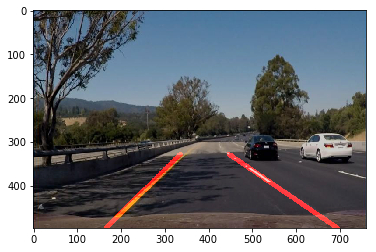

In [329]:
image = mpimg.imread('sample_images/DK2.jpg')
result = pipeline(image)
plt.imshow(result, cmap='gray')

## Test on Videos

In [330]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

## White Straight Line

In [331]:
# Empty list for Previous Value
Prev_L_Avg_slope = []
Prev_L_Avg_intercept = []
Prev_R_Avg_slope = []
Prev_R_Avg_intercept = []

# Number of average frame for tracking
smoothing = Line(n_smooth=15)

# Test on video (White straight line only)

white_output = 'white_result.mp4'
clip1 = VideoFileClip("white.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 69.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 3.57 s


## Yellow & White Straight Line

In [332]:
# Empty list for Previous Value
Prev_L_Avg_slope = []
Prev_L_Avg_intercept = []
Prev_R_Avg_slope = []
Prev_R_Avg_intercept = []

# Number of average frame for tracking
smoothing = Line(n_smooth=20)

# Test on video (Yellow & White straight line)

yellow_output = 'yellow_result.mp4'
clip2 = VideoFileClip('yellow.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:10<00:00, 65.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 10.8 s


## Yellow & White Curved Line with Shadow & Light

In [335]:
# Empty list for Previous Value
Prev_L_Avg_slope = []
Prev_L_Avg_intercept = []
Prev_R_Avg_slope = []
Prev_R_Avg_intercept = []

# Number of average frame for tracking
smoothing = Line(n_smooth=20)

# Test on video (Yellow & White curved line with harsh shadow & light condition)

challenge_output = 'challenge_result.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenging.mp4
[MoviePy] Writing video challenging.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:08<00:00, 29.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenging.mp4 

Wall time: 9.14 s
